# Análisis exploratorio de noticias
Este cuaderno carga un resumen inicial del archivo `data/raw/noticias.csv` sin necesidad de leerlo completo.


In [1]:
from pathlib import Path
import pandas as pd

data_path = Path('data/raw/noticias.csv')
if not data_path.exists():
    raise FileNotFoundError(f'No se encontró el archivo: {data_path}')

file_size_mb = data_path.stat().st_size / (1024 ** 2)
file_size_mb


6937.128843307495

In [2]:
# Solo leemos la fila de encabezados para obtener los nombres de columna
column_names = pd.read_csv(data_path, nrows=0).columns.tolist()
print(f'Total de columnas: {len(column_names)}')
column_names


Total de columnas: 8


['Unnamed: 0',
 'id',
 'title',
 'body',
 'source',
 'country',
 'publish_date',
 'platform']

In [3]:
# Muestreamos unas filas para revisar el contenido sin cargar todo el CSV
sample = pd.read_csv(data_path, nrows=5)
sample


,Unnamed: 0,id,title,body,source,country,publish_date,platform
0,0,14fae92262bf935db2acd1b27326a7ce832446f3ae29f4...,Incendio en el centro de Iquique dejó al menos...,"Durante la madrugada de este domingo, un incen...",24horas.cl,Chile,2019-11-17,Event Registry
1,1,0ebd40ff8cf0d0e72d33595efd0d55e3f29bd63c5255ce...,EE.UU. sanciona al ministro del Interior cuban...,Según el comunicado difundido por la oficina d...,24horas.cl,Chile,2019-11-17,Event Registry
2,2,4ddf688088b0b404dc739602d0efa40f29662d81ad0b0c...,General Rozas y actuar de Carabineros: No es p...,El General Director de Carabineros leyó un com...,24horas.cl,Chile,2019-11-17,Event Registry
3,3,4615e874256022f2d724bdaf9418e48bd159d7eb4c8033...,"Bachelet por crisis en Bolivia: ""Esta situació...",La Alta Comisionada de la ONU para los Derecho...,24horas.cl,Chile,2019-11-17,Event Registry
4,4,266463d44ea2a15ade44c267ea2de44ff6e85c4a814c0b...,Tsitsipas vence a Thiem en dramático duelo y s...,El griego venció al pupilo de Nicolás Massú y ...,24horas.cl,Chile,2019-11-17,Event Registry


In [4]:
# Conteo de las fuentes más frecuentes
top_sources = (
    pd.read_csv(data_path, usecols=['source'])['source']
    .value_counts(dropna=False)
    .head(10)
    .rename_axis('source')
    .reset_index(name='count')
)
top_sources


,source,count
0,biobiochile.cl,292625
1,adnradio.cl,190145
2,cooperativa.cl,177038
3,latercera.com,141203
4,lacuarta.com,136037
5,24horas.cl,133644
6,t13.cl,110839
7,radioagricultura.cl,108975
8,elmostrador.cl,105529
9,elciudadano.com,95115


## Carga a DataFrame y conteo global
Configura un modo de muestra para pruebas rapidas y calcula el total de filas del CSV.


In [5]:
LOAD_SAMPLE = True
SAMPLE_ROWS = 200_000
LOAD_COLUMNS = ['id', 'title', 'source', 'country', 'publish_date', 'platform']

def count_total_rows(path):
    with path.open('r', encoding='utf-8', errors='ignore') as fh:
        next(fh, None)
        return sum(1 for _ in fh)

read_kwargs = {}
if LOAD_COLUMNS:
    read_kwargs['usecols'] = LOAD_COLUMNS

if LOAD_SAMPLE:
    df = pd.read_csv(data_path, nrows=SAMPLE_ROWS, **read_kwargs)
else:
    df = pd.read_csv(data_path, **read_kwargs)

total_news = count_total_rows(data_path)
print(f'Total de noticias en el CSV: {total_news:,}')
print(f'Filas cargadas en este DataFrame: {len(df):,}')
df.head(3)


Total de noticias en el CSV: 48,450,538
Filas cargadas en este DataFrame: 200,000


,id,title,source,country,publish_date,platform
0,14fae92262bf935db2acd1b27326a7ce832446f3ae29f4...,Incendio en el centro de Iquique dejó al menos...,24horas.cl,Chile,2019-11-17,Event Registry
1,0ebd40ff8cf0d0e72d33595efd0d55e3f29bd63c5255ce...,EE.UU. sanciona al ministro del Interior cuban...,24horas.cl,Chile,2019-11-17,Event Registry
2,4ddf688088b0b404dc739602d0efa40f29662d81ad0b0c...,General Rozas y actuar de Carabineros: No es p...,24horas.cl,Chile,2019-11-17,Event Registry


### Incorporar la columna `body` después de haber cargado una muestra
Si la muestra actual se creó sin `body`, recreamos un mapeo desde el CSV original y lo fusionamos por `id`.


In [ ]:
NEED_BODY = 'body' not in df.columns
BODY_CHUNKSIZE = 250_000

if NEED_BODY:
    target_ids = set(df['id'])
    body_lookup = {}
    for chunk in pd.read_csv(data_path, usecols=['id', 'body'], chunksize=BODY_CHUNKSIZE):
        matches = chunk[chunk['id'].isin(target_ids)]
        body_lookup.update(zip(matches['id'], matches['body']))
        target_ids -= set(matches['id'])
        print(f"Quedan {len(target_ids):,} ids por resolver")
        if not target_ids:
            break
    df['body'] = df['id'].map(body_lookup)
    missing = df['body'].isna().sum()
    print(f"Se añadieron cuerpos para {len(df) - missing:,} noticias; sin cuerpo: {missing:,}")
else:
    print('La columna body ya está presente en el DataFrame.')

df[['id', 'title', 'body']].head(3)



## Preprocesamiento de titulos
Normaliza los titulos para reducir variantes y dejar el texto listo para posteriores pasos.


In [6]:
import re
import unicodedata

def normalize_title(text):
    if not isinstance(text, str):
        return ''
    text = unicodedata.normalize('NFKC', text)
    text = ''.join(ch for ch in text if not unicodedata.combining(ch))
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

df['title_normalized'] = df['title'].fillna('').map(normalize_title)
df[['title', 'title_normalized']].head(5)


,title,title_normalized
0,Incendio en el centro de Iquique dejó al menos...,incendio en el centro de iquique dejó al menos...
1,EE.UU. sanciona al ministro del Interior cuban...,ee.uu. sanciona al ministro del interior cuban...
2,General Rozas y actuar de Carabineros: No es p...,general rozas y actuar de carabineros: no es p...
3,"Bachelet por crisis en Bolivia: ""Esta situació...","bachelet por crisis en bolivia: ""esta situació..."
4,Tsitsipas vence a Thiem en dramático duelo y s...,tsitsipas vence a thiem en dramático duelo y s...


## Extraccion de personas en titulos (NER)
Usa spaCy con procesamiento en lotes para detectar entidades de tipo persona y agregarlas como nueva columna.


In [8]:
import spacy

try:
    GPU_ACTIVE = spacy.require_gpu()
except Exception:
    GPU_ACTIVE = spacy.prefer_gpu()

MODEL_NAME = 'es_core_news_md'
nlp = spacy.load(MODEL_NAME)
for pipe_name in ['tok2vec', 'morphologizer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']:
    if pipe_name in nlp.pipe_names:
        nlp.disable_pipe(pipe_name)

BATCH_SIZE = 4096
N_PROCESS = 12
TARGET_LABELS = {'PER', 'PERSON'}

def iter_person_entities(texts, batch_size=BATCH_SIZE, n_process=N_PROCESS):
    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process):
        yield sorted({ent.text for ent in doc.ents if ent.label_ in TARGET_LABELS})

persons = list(iter_person_entities(df['title'].fillna('')))
df['personas_title'] = persons
df['personas_title_count'] = [len(p) for p in persons]
df[['id', 'title', 'personas_title', 'personas_title_count']].head(5)


,id,title,personas_title,personas_title_count
0,14fae92262bf935db2acd1b27326a7ce832446f3ae29f4...,Incendio en el centro de Iquique dejó al menos...,[],0
1,0ebd40ff8cf0d0e72d33595efd0d55e3f29bd63c5255ce...,EE.UU. sanciona al ministro del Interior cuban...,[],0
2,4ddf688088b0b404dc739602d0efa40f29662d81ad0b0c...,General Rozas y actuar de Carabineros: No es p...,"[Abel Acuña, General Rozas]",2
3,4615e874256022f2d724bdaf9418e48bd159d7eb4c8033...,"Bachelet por crisis en Bolivia: ""Esta situació...",[Bachelet],1
4,266463d44ea2a15ade44c267ea2de44ff6e85c4a814c0b...,Tsitsipas vence a Thiem en dramático duelo y s...,"[Thiem, Tsitsipas]",2


### Procesamiento por lotes para el dataset completo
Ejemplo de flujo para anotar todas las noticias en chunks y guardar resultados incrementales.


In [9]:
from pathlib import Path

def annotate_dataset(csv_path, chunksize=250_000, batch_size=BATCH_SIZE, n_process=N_PROCESS):
    read_kwargs = {}
    if LOAD_COLUMNS:
        read_kwargs['usecols'] = LOAD_COLUMNS
    for chunk_idx, chunk in enumerate(pd.read_csv(csv_path, chunksize=chunksize, **read_kwargs)):
        chunk['title_normalized'] = chunk['title'].fillna('').map(normalize_title)
        persons_chunk = list(iter_person_entities(chunk['title'].fillna(''), batch_size=batch_size, n_process=n_process))
        chunk['personas_title'] = persons_chunk
        chunk['personas_title_count'] = [len(p) for p in persons_chunk]
        yield chunk

# Ejemplo de persistencia incremental en CSV (ajusta la ruta a tus necesidades).
output_path = Path('data/processed/noticias_personas.csv')
output_path.parent.mkdir(parents=True, exist_ok=True)
for idx, processed_chunk in enumerate(annotate_dataset(data_path)):
    processed_chunk.to_csv(
        output_path,
        mode='a',
        index=False,
        header=idx == 0
    )
    print(f'Chunk {idx} guardado con {len(processed_chunk):,} filas')

print('Procesamiento completado')


Chunk 0 guardado con 250,000 filas
Chunk 1 guardado con 250,000 filas
Chunk 2 guardado con 250,000 filas
Chunk 3 guardado con 250,000 filas
Chunk 4 guardado con 250,000 filas
Chunk 5 guardado con 250,000 filas
Chunk 6 guardado con 250,000 filas
Chunk 7 guardado con 250,000 filas
Chunk 8 guardado con 250,000 filas
Chunk 9 guardado con 250,000 filas
Chunk 10 guardado con 250,000 filas
Chunk 11 guardado con 159,528 filas
Procesamiento completado


### Enriquecer archivos procesados existentes con `body`
Fusiona `data/processed/noticias_personas.csv` con el texto original desde `data/raw/noticias.csv` usando `id`.
El flujo usa DuckDB para evitar cargar los ~6 millones de filas íntegramente en pandas.


In [ ]:
import pandas as pd
from pathlib import Path

# --- Rutas ---
processed_path = Path("data/processed/noticias_personas.csv")
raw_body_path  = Path("data/raw/noticias.csv")
output_path    = Path("data/processed/noticias_personas_con_body.csv")

# --- Cargar dataframes ---
df_personas = pd.read_csv(processed_path)
df_raw      = pd.read_csv(raw_body_path, usecols=["id", "body"])  # solo tomamos id y body

# --- Merge por 'id' ---
df_merged = df_personas.merge(df_raw, on="id", how="left")


AttributeError: 'DataFrame' object has no attribute 'csv'

In [32]:

df_merged.to_csv(output_path, index=False)

print(f"Archivo enriquecido guardado en: {output_path}")
print(df_merged.head())



Archivo enriquecido guardado en: data\processed\noticias_personas_con_body.csv
                                                  id  \
0  14fae92262bf935db2acd1b27326a7ce832446f3ae29f4...   
1  0ebd40ff8cf0d0e72d33595efd0d55e3f29bd63c5255ce...   
2  4ddf688088b0b404dc739602d0efa40f29662d81ad0b0c...   
3  4615e874256022f2d724bdaf9418e48bd159d7eb4c8033...   
4  266463d44ea2a15ade44c267ea2de44ff6e85c4a814c0b...   

                                               title      source country  \
0  Incendio en el centro de Iquique dejó al menos...  24horas.cl   Chile   
1  EE.UU. sanciona al ministro del Interior cuban...  24horas.cl   Chile   
2  General Rozas y actuar de Carabineros: No es p...  24horas.cl   Chile   
3  Bachelet por crisis en Bolivia: "Esta situació...  24horas.cl   Chile   
4  Tsitsipas vence a Thiem en dramático duelo y s...  24horas.cl   Chile   

  publish_date        platform  \
0   2019-11-17  Event Registry   
1   2019-11-17  Event Registry   
2   2019-11-17  Event Reg

# Pre filtrado de noticias

In [34]:
df = pd.read_csv('data/processed/noticias_personas_con_body.csv')



In [41]:
df

,id,title,source,country,publish_date,platform,title_normalized,personas_title,personas_title_count,body,year_month
0,14fae92262bf935db2acd1b27326a7ce832446f3ae29f4...,Incendio en el centro de Iquique dejó al menos...,24horas.cl,Chile,2019-11-17,Event Registry,incendio en el centro de iquique dejó al menos...,[],0,"Durante la madrugada de este domingo, un incen...",2019-11
1,0ebd40ff8cf0d0e72d33595efd0d55e3f29bd63c5255ce...,EE.UU. sanciona al ministro del Interior cuban...,24horas.cl,Chile,2019-11-17,Event Registry,ee.uu. sanciona al ministro del interior cuban...,[],0,Según el comunicado difundido por la oficina d...,2019-11
2,4ddf688088b0b404dc739602d0efa40f29662d81ad0b0c...,General Rozas y actuar de Carabineros: No es p...,24horas.cl,Chile,2019-11-17,Event Registry,general rozas y actuar de carabineros: no es p...,"['Abel Acuña', 'General Rozas']",2,El General Director de Carabineros leyó un com...,2019-11
3,4615e874256022f2d724bdaf9418e48bd159d7eb4c8033...,"Bachelet por crisis en Bolivia: ""Esta situació...",24horas.cl,Chile,2019-11-17,Event Registry,"bachelet por crisis en bolivia: ""esta situació...",['Bachelet'],1,La Alta Comisionada de la ONU para los Derecho...,2019-11
4,266463d44ea2a15ade44c267ea2de44ff6e85c4a814c0b...,Tsitsipas vence a Thiem en dramático duelo y s...,24horas.cl,Chile,2019-11-17,Event Registry,tsitsipas vence a thiem en dramático duelo y s...,"['Thiem', 'Tsitsipas']",2,El griego venció al pupilo de Nicolás Massú y ...,2019-11
...,...,...,...,...,...,...,...,...,...,...,...
2912703,abc0b17f47c0c8a74644c586645f274d783a92f12ecc99...,El influencer que aterrizó sin permiso en la A...,tvn.cl,Chile,2025-07-07,Event Registry,el influencer que aterrizó sin permiso en la a...,[],0,"Por el momento, el piloto podría seguir en el ...",2025-07
2912704,881359ccc7c92cc7e315391ebeb066f8c9e010fa47a561...,De vacaciones y con exitoso futbolista: ¿Quién...,tvn.cl,Chile,2025-07-07,Event Registry,de vacaciones y con exitoso futbolista: ¿quién...,['Coté López'],1,La influencer se habría reunido con el jugador...,2025-07
2912705,b4a8da03372ccde02398bb7e39695406b5a78142b75b95...,Christell Rodríguez deslumbra y se llena de el...,tvn.cl,Chile,2025-07-07,Event Registry,christell rodríguez deslumbra y se llena de el...,['Christell Rodríguez'],1,Las redes sociales se rindieron con la partici...,2025-07
2912706,93ec3d6a86a895c25034a79875c326f1be243cefeda246...,Gepe y Ana Tijoux se consagran como los grande...,tvn.cl,Chile,2025-07-07,Event Registry,gepe y ana tijoux se consagran como los grande...,['Ana Tijoux'],1,"Manuel García, Electrodomésticos, Marlon Breez...",2025-07


In [42]:
# 1. Contar las noticias por cada 'source' y obtener las 10 principales
top_10_sources = df['source'].value_counts().nlargest(10).index

print("Las 10 fuentes con más noticias son:")
print(top_10_sources)

# 2. Filtrar el DataFrame para mantener solo las filas de esas 10 fuentes
# A partir de aquí, el resto de tu script trabajará solo con este DF filtrado.
df = df[df['source'].isin(top_10_sources)].copy()

print(f"\nEl DataFrame ahora tiene {len(df)} filas, correspondientes solo a las 10 fuentes principales.")


Las 10 fuentes con más noticias son:
Index(['biobiochile.cl', 'adnradio.cl', 'cooperativa.cl', 'latercera.com',
       'lacuarta.com', '24horas.cl', 't13.cl', 'radioagricultura.cl',
       'elmostrador.cl', 'elciudadano.com'],
      dtype='object', name='source')

El DataFrame ahora tiene 1492730 filas, correspondientes solo a las 10 fuentes principales.


In [14]:
def count_persons(value):
    if isinstance(value, (list, tuple, set)):
        return len(value)
    if isinstance(value, str):
        # por si cargaste desde CSV y quedó como texto "[...]"
        try:
            import ast
            parsed = ast.literal_eval(value)
            if isinstance(parsed, (list, tuple, set)):
                return len(parsed)
        except Exception:
            pass
    return 0

df["n_personas"] = df["personas_title"].map(count_persons)


In [43]:
body_len = df['body'].fillna('').str.len()
df = df[body_len.between(2500, 10000)]


In [45]:
df["n_personas"] = df["personas_title"].map(count_persons)

# Contar filas con 1 o más personas
count_1_plus = (df["n_personas"] >= 1).sum()

# Contar filas con 2 o más personas
count_2_plus = (df["n_personas"] >= 2).sum()

print("Filas con ≥1 persona:", count_1_plus)
print("Filas con ≥2 personas:", count_2_plus)

Filas con ≥1 persona: 141557
Filas con ≥2 personas: 35975


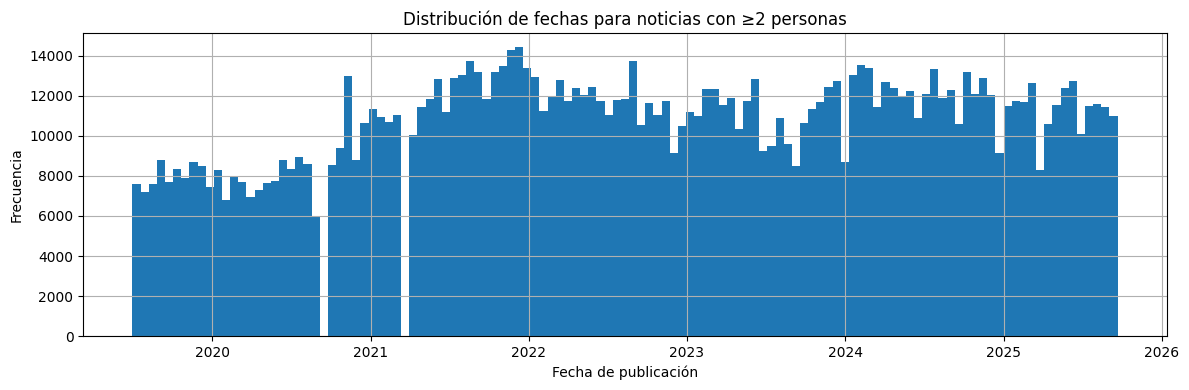

In [38]:
import matplotlib.pyplot as plt

# Asegúrate de tener la columna de fechas como datetime
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')

# Filtrar las filas con ≥2 personas
mask = df['personas_title_count'] >= 1
df_2_plus = df.loc[mask & df['publish_date'].notna()]


# Opción 2: histograma continuo (bins de días/semanas)
df_2_plus['publish_date'].hist(
    bins='auto', figsize=(12, 4)
)
plt.title('Distribución de fechas para noticias con ≥2 personas')
plt.xlabel('Fecha de publicación')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


In [47]:
import pandas as pd

# Asegúrate de tener la columna de fechas como datetime
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')

# Eliminar filas donde la fecha no se pudo convertir
df = df.dropna(subset=['publish_date'])

# Crear una columna con el año y el mes para agrupar
df['year_month'] = df['publish_date'].dt.to_period('M')

# DataFrame para almacenar el resultado final
df_subset = pd.DataFrame()

# Iterar sobre cada mes en los datos
for month in df['year_month'].unique():
    df_month = df[df['year_month'] == month]

    # Separar las noticias por prioridad
    high_priority = df_month[df_month['personas_title_count'] >= 2]
    low_priority = df_month[df_month['personas_title_count'] == 1]

    # Lógica para seleccionar 5000 noticias
    if len(high_priority) >= 500:
        # Si hay 5000 o más de alta prioridad, tomar una muestra
        monthly_sample = high_priority.sample(n=500, random_state=42)
    else:
        # Si hay menos de 5000 de alta prioridad, tomarlas todas
        monthly_sample = high_priority
        needed = 500 - len(high_priority)
        
        # Rellenar con las de baja prioridad
        if needed > 0 and len(low_priority) > 0:
            # Tomar las noticias de baja prioridad necesarias, si las hay
            low_priority_sample = low_priority.sample(n=min(needed, len(low_priority)), random_state=42)
            monthly_sample = pd.concat([monthly_sample, low_priority_sample])

    # Añadir el subconjunto del mes al DataFrame final
    df_subset = pd.concat([df_subset, monthly_sample])

# Opcional: Reordenar el DataFrame por fecha
df_subset = df_subset.sort_values(by='publish_date')

# Opcional: Verificar cuántas noticias tienes por mes en el nuevo subset
print("Noticias por mes en el subset final:")
print(df_subset['year_month'].value_counts().sort_index())

# Ahora `df_subset` contiene los datos que querías
print("\nPrimeras filas del subset generado:")
print(df_subset.head())

Noticias por mes en el subset final:
year_month
2019-07    500
2019-08    500
2019-09    500
2019-10    500
2019-11    500
          ... 
2025-05    500
2025-06    500
2025-07    500
2025-08    500
2025-09    500
Freq: M, Name: count, Length: 75, dtype: int64

Primeras filas del subset generado:
                                                       id  \
182940  1073f805cdc17e54d7ff9de18301a2dee8afa5fb32930f...   
182551  40abf2b284f0f13adfa27720e930893cc6da109750a498...   
183041  b3ae8649ce749529f4dc7790f38890962e5df7d02ac644...   
182956  63186f238015f6ec5ece5502098f4485400e8f31daff4a...   
182955  5575cf97e6f0c11ba14ea3e49e94e892f9175888dd62a4...   

                                                    title          source  \
182940  José Maza intentará batir un récord Guinness c...  elmostrador.cl   
182551  PiÃ±era tilda paro de profesores como ilegal y...  biobiochile.cl   
183041  Jorge Aravena: "Siempre le preguntaba a Charle...    lacuarta.com   
182956  Ganó el Sí: se impon

In [51]:
df_subset.drop_duplicates(subset='title', inplace=True)

In [53]:
df_subset.to_csv('data/processed/pruebaV1.csv')